In [1]:
import numpy as np
import pandas as pd 
import random
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

sns.set_style("whitegrid")
random_state=42
import warnings; warnings.simplefilter('ignore')

/Users/polinab/.virtualenvs/base/lib/python3.8/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


### Step 1: generate d-dimensional hypercube

In [2]:
def assign_y_val(x_i):
    return 1 if all([x >= -1 and x <= 1 for x in x_i]) else 0

def gen_cube(n,d):
    Xs = np.random.uniform(-2**(1/d),2**(1/d),size=(n,d))
    Ys = [assign_y_val(x) for x in Xs]
    mtx = []
    for i in range(n):
        mtx.append(np.append(Xs[i],Ys[i]))
    return mtx


In [3]:
d = 4
n = 1000

cube = gen_cube(n,d)
df = pd.DataFrame(data=cube)
df = df.rename(columns={0:'X0',1:'X1',2:'X2',3:'X3',4:'Y'})
df

,X0,X1,X2,X3,Y
0,0.054332,-1.080480,-1.053012,-0.344237,0.0
1,-0.996267,0.404284,-0.754069,-0.106395,1.0
2,-1.036456,-0.756692,-1.015865,0.614768,0.0
3,-1.024411,0.020754,-0.595751,1.094336,0.0
4,-0.073626,1.055322,0.208340,0.516136,0.0
...,...,...,...,...,...
995,-0.700761,-1.168707,0.669377,-0.474740,0.0
996,1.077118,-0.027061,-0.645163,1.164912,0.0
997,0.642844,-0.345491,-0.892983,0.775181,1.0
998,-1.147345,-0.980344,1.186509,1.072972,0.0


Text(0.5, 0.98, 'Relationships of different dimensions of X to Y')

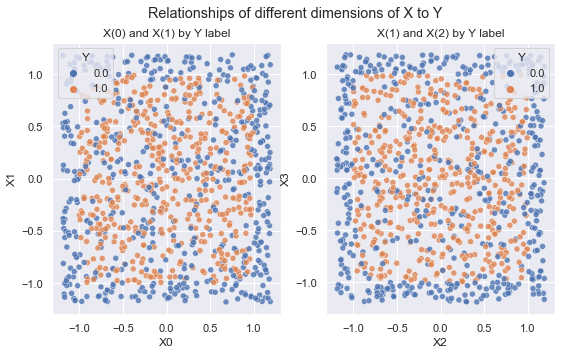

In [4]:
sns.set(rc={'figure.figsize':(9,5)})
fig, ax =plt.subplots(1,2)
a = sns.scatterplot(data=df, x='X0', y='X1', hue='Y',alpha=0.8,ax=ax[0])
b = sns.scatterplot(data=df, x='X2', y='X3', hue='Y',alpha=0.8,ax=ax[1])
a.set_title('X(0) and X(1) by Y label')
b.set_title('X(1) and X(2) by Y label')
fig.suptitle('Relationships of different dimensions of X to Y')

### Step 2: Build first classifier - Square
\[-a,a\]^d

In [5]:

def get_min_dimension(mycube):
    d = len(mycube[0][:-1])
    cube_1 = [row[:-1] for row in mycube if row[-1] == 1.0]
    return np.amax(list(map(abs, cube_1))) #finds max absolute value of all x values in cube
    

In [6]:
def row_in_range(bdim,r):
    return np.all([abs(x) <= bdim for x in r])

def points_within_square(bdim,cube):
    cube_1 = [row[:-1] for row in cube if row[-1] == 1.0]
    in_range = [row_in_range(bdim,i[:-1]) for i in cube_1].count(True)
    return in_range/len(cube_1)

In [7]:
bounding_dim = get_min_dimension(cube)
test_cube = gen_cube(n,d)


In [8]:

points_within_square(bounding_dim, test_cube)


0.9979296066252588

### Step 3:  Build second classifier - rectangle
\[a1,b1\] x ... x \[ad, bd\]

In [9]:


def get_bounding_dims(cube):
    d = len(cube[0][:-1])
    cube_1 = [row[:-1] for row in cube if row[-1] == 1.0]
    mins = [min([row[i] for row in cube_1]) for i in range(d)]
    maxs = [max([row[i] for row in cube_1]) for i in range(d)]
    return [[mins[i],maxs[i]] for i in range(d)]

def points_within_rec(bdims,cube):
    cube_1 = [row[:-1] for row in cube if row[-1] == 1.0]
    d = len(cube_1[0])
    boolean_cube = [[bdims[i][0] <= row[i] and bdims[i][1] >= row[i] for row in cube_1] for i in range(d)]
    in_range = [all(row) for row in np.transpose(boolean_cube)].count(True)
    return scipy.mean(in_range/len(cube_1))



In [10]:
bdims = get_bounding_dims(cube)
bdims

[[-0.9997622596932966, 0.9967385995439668],
 [-0.9976055866937313, 0.9897652251446789],
 [-0.9995610773571384, 0.9950478879312794],
 [-0.9940190701569658, 0.999638886198188]]

In [11]:
test_cube = gen_cube(n,d)
points_within_rec(bdims,test_cube)


0.9880239520958084

### Step 4: plot over range of n, d

In [12]:
def acc_over_range_n(r,d,t):
    Ps = []
    for n in r:
        train_cube = gen_cube(n,d)
        test_cube = gen_cube(n,d)
        if t == 's':
            b_dim = get_min_dimension(train_cube)
            Ps.append(points_within_square(b_dim, test_cube))
        else:
            b_dim = get_bounding_dims(train_cube)
            Ps.append(points_within_rec(b_dim, test_cube))
        
    return Ps

def acc_over_range_d(r,n,t):
    Ps = []
    for d in r:
        train_cube = gen_cube(n,d)
        test_cube = gen_cube(n,d)  
        if t == 's':
            b_dim = get_min_dimension(train_cube)
            Ps.append(points_within_square(b_dim, test_cube))
        else:
            b_dim = get_bounding_dims(train_cube)
            Ps.append(points_within_rec(b_dim, test_cube))
    return Ps


def repeated_accuracy_n(acc_range,d,reps,t):
    probs = {i: acc_over_range_n(acc_range,d,t) for i in range(reps)}
    return [scipy.mean([probs[i][j] for i in range(reps)]) for j in range(len(probs[0]))]

def repeated_accuracy_d(acc_range,n,reps,t):
    probs = {i: acc_over_range_d(acc_range,n,t) for i in range(reps)}
    return [scipy.mean([probs[i][j] for i in range(reps)]) for j in range(len(probs[0]))]


In [13]:
# square
acc_range = range(50, 1000,10)
reps = 10
d = 5
probs = repeated_accuracy_n(acc_range,d,reps,'s')


In [14]:
data_sq = pd.DataFrame({'n':[n for n in acc_range], 'error':[1-p for p in probs]})

In [15]:
#rectangle
acc_range = range(50, 1000,10)
reps = 10
d = 5
probs = repeated_accuracy_n(acc_range,d,reps,'r')

In [16]:
data_rec = pd.DataFrame({'n':[n for n in acc_range], 'error':[1-p for p in probs]})

Text(0.5, 1.0, 'Rectangle Estimator')

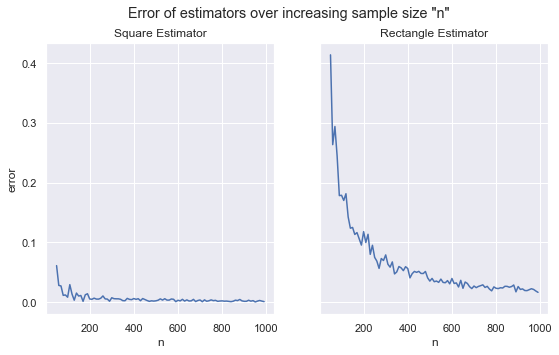

In [17]:
sns.set(rc={'figure.figsize':(9,5)})
fig, ax =plt.subplots(1,2,sharey=True)
plt.suptitle('Error of estimators over increasing sample size "n"')
sq = sns.lineplot(data=data_sq, x="n", y="error",ax=ax[0])
rec = sns.lineplot(data=data_rec, x="n", y="error",ax=ax[1])

sq.set_title('Square Estimator')
rec.set_title('Rectangle Estimator')



In both graphs, higher sample sizes decrease error. However, in the case of the square estimator, there is not much change after the sample size reaches about 200. In the case of the rectangle estimator, the error is decreasing exponentially at a higher rate, and starts from a higher value. <br> In the case of the cube, adding more values would not necessarily change the maximum value, as long as all points are taken from the same distribution. At very small n values, it is possible that the bounding value would be too small if the sample is missing sufficient points at the boundary. This explains the higher error values at low n values for the square estimator.<br> Since the rectangle uses more "customized" values for min and max in each dimension, adding more data points will greatly improve the accuracy of the bounding values generated. 

In [18]:
#square
acc_range = range(3, 60)
reps = 20
n = 1000
probs = repeated_accuracy_d(acc_range,n,reps,'s')
data_sq = pd.DataFrame({'d':[d for d in acc_range], 'error':[1-p for p in probs]})

In [19]:
# rectangle
acc_range = range(3, 60)
reps = 20
n = 1000
probs = repeated_accuracy_d(acc_range,n,reps,'r')
data_rec = pd.DataFrame({'d':[d for d in acc_range], 'error':[1-p for p in probs]})

Text(0.5, 1.0, 'Rectangle Estimator')

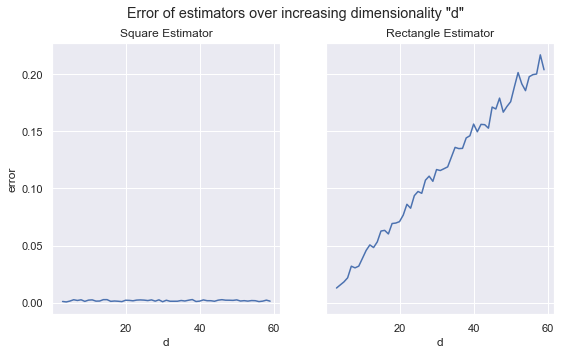

In [21]:
sns.set(rc={'figure.figsize':(9,5)})
fig, ax =plt.subplots(1,2,sharey=True)
plt.suptitle('Error of estimators over increasing dimensionality "d"')
sq = sns.lineplot(data=data_sq, x="d", y="error",ax=ax[0])
rec = sns.lineplot(data=data_rec, x="d", y="error",ax=ax[1])

sq.set_title('Square Estimator')
rec.set_title('Rectangle Estimator')

There is a clear difference at increasing dimensionality. The error for the square estimator shows no trend and stays very low, while the error for the rectangle estimator increases linearly.<br>
Adding more dimensions would not affect the square estimator, because it just takes the maximum value amongst all dimensions. However, the rectangle estimator generates min and max values that are different for each dimension, so every additional dimension adds potential variability, aka potential differences between the train and test data bounding values.